# MOF Recommender System: Analyzing data

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os

<p style="text-align: center;">=====================================================================================================</p>

### The following notebook is split up into two sections: <b>[Data Manipulation](#data_manipulation)</b> and <b>[Data Visualization](#data_visualization)</b>

<a id='data_manipulation'></a>
# Data Manipulation

### Creating a Dictionary that converts InChIKey to gas and hashkey to mof

In [2]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

### Taking out non experimental isotherms (excluding uncategorized isotherm)

In [4]:
url = "https://" + host + "/isodb/api/isotherms.json"
isotherm_data = json.loads(requests.get(url).content)

experimental_isotherms = []
print("Number of isotherms before cutting non experimental: {}".format(len(isotherm_data)))

for isotherm in reversed(isotherm_data):
    if isotherm['category'] == 'exp' or isotherm['category'] == '':
        experimental_isotherms.append(isotherm)
experimental_isotherms = np.array(experimental_isotherms)
print("Number of isotherms after cutting non experimental: {}".format(len(experimental_isotherms)))

Number of isotherms before cutting non experimental: 30326
Number of isotherms after cutting non experimental: 28813


### Grabs units

In [5]:
filename = 'isotherm_file_units.csv'
units = []
filename_unit_dict = {}

# If `isotherm_file_units.csv` is not present, the following code will parse the database 
#  and grab the units of each isotherm file. The data will be written into a new `isotherm_file_units.csv` file
# WILL TAKE AROUND 3 HRS!
if os.path.isfile(filename):
    print('File already exists.\nWill not download isotherm data from NIST database')
    isotherm_unit_data = pd.read_csv(filename)
    units = isotherm_unit_data['units']
    for i in range(isotherm_unit_data.shape[0]):
        filename_unit_dict[isotherm_unit_data['isotherm_filename'][i]] = isotherm_unit_data['units'][i]
else:
    for isotherm in experimental_isotherms:
        filename = isotherm['filename']
        url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
        bibliography = json.loads(requests.get(url).content)
        units.append(bibliography['adsorptionUnits'])
        filename_unit_dict[filename] = bibliography['adsorptionUnits']
    with open(filename, 'w') as outfile:
        outfile.write('isotherm_filename,units\n')
        for i, isotherm in enumerate(experimental_isotherms):
            outfile.write(isotherm['filename'] + ',' + units[i] + '\n')

File already exists.
Will not download isotherm data from NIST database


### This takes out MOFS with non viable units, binary/tertiary isotherms

In [7]:
viable_units = ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
boolean_isotherm_array = [x_i in viable_units for x_i in units]

# Currently we will allow N2 and Ar isotherms to be at 77K and 87K, respectively, 
# and allow all isotherms around room temp, [293K, 303K].
n2_inchikey = 'IJGRMHOSHXDMSA-UHFFFAOYSA-N'
ar_inchikey = 'XKRFYHLGVUSROY-UHFFFAOYSA-N'

temp_groups = {key: '_298K' for key in range(293,304)}
temp_groups[77] = '_77K'
temp_groups[87] = '_87K'

print("Number of Isotherms before cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#Makes the boolean array false if the the units aren't viable or the gas is a mixture
for (i, isotherm) in enumerate(experimental_isotherms):
    if boolean_isotherm_array[i] and len(isotherm['adsorbates']) > 1:
        boolean_isotherm_array[i] = False
    if not ((isotherm['temperature'] <= 303 and isotherm['temperature'] >= 293) or
            (isotherm['adsorbates'][0]['InChIKey'] == n2_inchikey and isotherm['temperature'] == 77) or
            (isotherm['adsorbates'][0]['InChIKey'] == ar_inchikey and isotherm['temperature'] == 87)):
        boolean_isotherm_array[i] = False
        
print("Number of Isotherms after cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#The below two for loops take every experimental mof and gas and number them 
count = 0
mof_to_row = {}
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    if isotherm['adsorbent']['hashkey'] not in mof_to_row:
        mof_to_row[isotherm['adsorbent']['hashkey']] = count
        count += 1

row_to_mof = dict(map(reversed, mof_to_row.items())) #creates an inverted dictionary

count = 0
gas_temp_to_column = {}
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    key = isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]
    if key not in gas_temp_to_column:
        gas_temp_to_column[key] = count
        count += 1
        
column_to_gas_temp = dict(map(reversed, gas_temp_to_column.items())) #creates an inverted dictionary

print("Number of gases/temps in the matrix: {}".format(len(gas_temp_to_column)))
print("Number of mofs in the matrix: {}".format(len(mof_to_row)))

Number of Isotherms before cutting non viable units and gas mixtures: 24878
Number of Isotherms after cutting non viable units and gas mixtures: 13258
Number of gases/temps in the matrix: 87
Number of mofs in the matrix: 4012


### This fills in the matrix

In [8]:
#Setting up a matrix of mofs and gases for available data and frequency of isotherms
mof_gas_matrix = np.zeros((len(mof_to_row),len(gas_temp_to_column)))
mof_gas_frequency = np.zeros((len(mof_to_row),len(gas_temp_to_column)))
mof_gas_temp_to_filename = {}

#Now to fill in the matrix
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    row_value = mof_to_row[isotherm['adsorbent']['hashkey']]
    column_value = gas_temp_to_column[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]]
    if isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']] not in mof_gas_temp_to_filename.keys():
        mof_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]] = {}
    if isotherm['adsorbent']['hashkey'] not in mof_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]].keys():
        mof_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]][isotherm['adsorbent']['hashkey']] = []
    mof_gas_temp_to_filename[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]][isotherm['adsorbent']['hashkey']].append(isotherm['filename'])
    mof_gas_matrix[row_value,column_value] = 1
    mof_gas_frequency[row_value,column_value] += 1
    
with open('mof_gas_to_filename.json', 'w') as outfile:
    json.dump(mof_gas_temp_to_filename, outfile)

### Checking to see if all gas mixtures were successfully "taken out" of experimental_isotherm

In [9]:
for (i, isotherm) in enumerate(experimental_isotherms):
    if len(isotherm['adsorbates']) > 1:
        assert not boolean_isotherm_array[i]
    assert filename_unit_dict[isotherm['filename']] in viable_units or not boolean_isotherm_array[i]

### This takes a random value from the matrix to see if there is isotherm data on it and prints the isotherm data if present

In [92]:
count = 1
while True:
    gas_number = random.choice(range(len(gas_temp_to_column)))
    mof_number = random.choice(range(len(mof_to_row)))
    if mof_gas_matrix[mof_number,gas_number] == 1:
        for isotherm in experimental_isotherms:
            if isotherm['temperature'] not in temp_groups.keys():
                continue
            if isotherm['adsorbent']['hashkey'] == row_to_mof[mof_number] and isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']] == column_to_gas_temp[gas_number]:
                url = "https://adsorption.nist.gov/isodb/api/isotherm/" + isotherm['filename'] + ".json"
                bibliography = json.loads(requests.get(url).content)
                if bibliography['adsorptionUnits'] in viable_units and len(bibliography['adsorbates']) == 1 and isotherm['category'] in ['exp', '']:
                    print('Isotherm ' + str(count) + ' satisfies all conditions!')
                #pprint.pprint(bibliography) <-- if you want to check the actual isotherm file
                count += 1
        break

Isotherm 1 satisfies all conditions!


### Another Check to see if the matrix is correct

In [93]:
#This just tests to see if the matrix is correct, you can see the amount of gases each isotherm has and compare it to the matrix
#material_code[experimental_isotherm[12]['adsorbent']['hashkey']] correspnds with the first term in the matrix 'CuBTC'
#Code should give 53 different gases that 'CuBTC' has been tested with because that is the number that the number of ones in the sparsity matrix

CuBTC_hashkey = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
test_array=[]
for isotherm in experimental_isotherms[boolean_isotherm_array]:
    if isotherm['adsorbent']['hashkey'] == CuBTC_hashkey:
        test_array.append(key_to_gas[isotherm['adsorbates'][0]['InChIKey']])

print('The gases that are tested with CuBTC:') 
pprint.pprint(set(test_array))
print('Number of gases in the list: {}'.format(len(set(test_array))))
print('Number of gasses in the first row of the matrix that corresponds with CuBTC: {}'.format(np.sum(mof_gas_matrix[0,:])))

The gases that are tested with CuBTC:
{'2-Methylbutane',
 'Acetone',
 'Acetylene',
 'Ammonia',
 'Argon',
 'Benzene',
 'Carbon Dioxide',
 'Carbon Tetrachloride',
 'Carbon Tetrafluoride',
 'Carbon monoxide',
 'Cyclopentane',
 'Dichloromethane',
 'Ethane',
 'Ethanol',
 'Ethene',
 'Hydrogen',
 'Isobutane',
 'Isobutene',
 'Methane',
 'Methanol',
 'N-Butane',
 'N-Hexane',
 'N-Pentane',
 'N-propane',
 'Nitric oxide',
 'Nitrogen',
 'Oxygen',
 'Propene',
 'Sulfur dioxide',
 'Thiophene',
 'Trichloromethane',
 'Water',
 'Xenon'}
Number of gases in the list: 33
Number of gasses in the first row of the matrix that corresponds with CuBTC: 18.0


### This takes out rows and columns that have too little data

In [95]:
def prune_matrix(min_data_points, verbose=True):
    keep_row = np.ones(len(mof_to_row), dtype=bool)
    keep_column = np.ones(len(gas_temp_to_column), dtype=bool)
    nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
    gases_cut = 0
    mofs_cut = 0
    count = 0

    while True:
        for i_row in range(len(mof_to_row)):
            if np.sum(mof_gas_matrix[i_row, keep_column]) < min_data_points:
                keep_row[i_row] = False

        for i_column in range(len(gas_temp_to_column)):
            if np.sum(mof_gas_matrix[keep_row, i_column]) < min_data_points:
                keep_column[i_column] = False

        if nb_kept_rows_and_columns == (np.sum(keep_row) + np.sum(keep_column)):
            break

        nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
        count += 1

    mofs_cut = np.sum(~keep_row)
    gases_cut = np.sum(~keep_column)

    #TODO make another matrix that actually cuts the rows and the columns out
    if verbose:
        print("Number of mofs cut: {}" .format(mofs_cut))
        print("Number of gases cut: {}" .format(gases_cut))
        print('The remaining dimensions of the matrix are {} by {}'.format(len(mof_to_row)-mofs_cut,len(gas_temp_to_column)-gases_cut))
        print('The number of iterations of sparsing the matrix {}'.format(count))
    
    return keep_row, keep_column

keep_row, keep_column = prune_matrix(5)

Number of mofs cut: 3826
Number of gases cut: 47
The remaining dimensions of the matrix are 186 by 40
The number of iterations of sparsing the matrix 2


### Grabs individual isotherms for further analysis

In [96]:
for isotherm in experimental_isotherms:
    filename = isotherm['filename']
    if os.path.isfile('isotherms/' + filename + '.json'):
        #print(filename + '.json already exists')
        continue
    url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
    isotherm_data = json.loads(requests.get(url).content)
    with open('isotherms/' + filename + '.json', 'w') as outfile:
        json.dump(isotherm_data, outfile)

<a id='data_visualization'></a>
# Data Visualization

In [97]:
def sort_matrix_by_freq(mof_gas_matrix, row_or_col):
    assert row_or_col in ['row', 'col']
    row_or_col_axis = np.int(row_or_col == 'row')
    row_or_col_sum = np.sum(mof_gas_matrix, axis=row_or_col_axis)
    len_other_axis = mof_gas_matrix.shape[row_or_col_axis]
    old_order = np.array([i for i in range(len(row_or_col_sum))])
    new_order = sorted(old_order, key=lambda x: row_or_col_sum[x], reverse=True)
    other_axis_order = np.array([i for i in range(len_other_axis)])
    if row_or_col == 'row':
        return mof_gas_matrix[new_order, :]
    else:
        return mof_gas_matrix[:, new_order]

### Analyzing the categories of the isotherms

The amount of uncategorized isotherms is 23090
The amount of epxerimental isotherms is 5723
The amount of modelled isotherms is 460
The amount of quantum isotherms is 118
The amount of simulated isotherms is 935


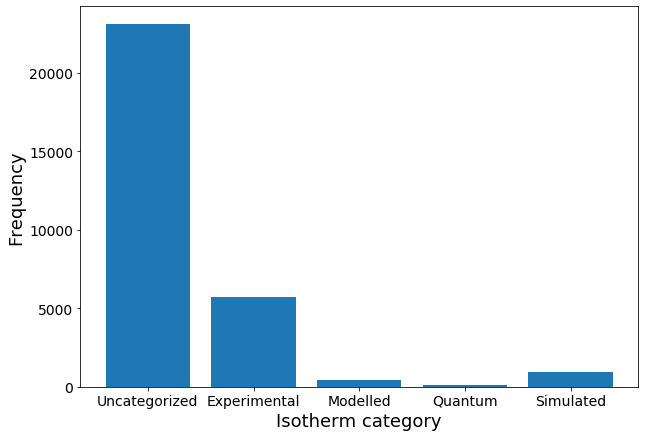

In [98]:
isotherm_category = []
for isotherm in isotherm_data:
    isotherm_category.append(isotherm['category'])

n_uncategorized = isotherm_category.count('')
n_experimental = isotherm_category.count('exp')
n_mod = isotherm_category.count('mod')
n_qua = isotherm_category.count('qua')
n_simulated = isotherm_category.count('sim')

print('The amount of uncategorized isotherms is {}'.format(n_uncategorized))
print('The amount of epxerimental isotherms is {}'.format(n_experimental))
print('The amount of modelled isotherms is {}'.format(n_mod))
print('The amount of quantum isotherms is {}'.format(n_qua))
print('The amount of simulated isotherms is {}'.format(n_simulated))


category_labels = ("Uncategorized", "Experimental", "Modelled", "Quantum", "Simulated")
y_pos = np.arange(len(category_labels))
bar_height = [n_uncategorized, n_experimental, n_mod, n_qua, n_simulated]

fig = plt.figure(figsize = (10,7))
ax = plt.gca()
ax.bar(y_pos, bar_height, align='center', alpha=1)
plt.xticks(y_pos, category_labels)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Isotherm category', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)



plt.show()

### Analyzing the temperature ranges in the dataset

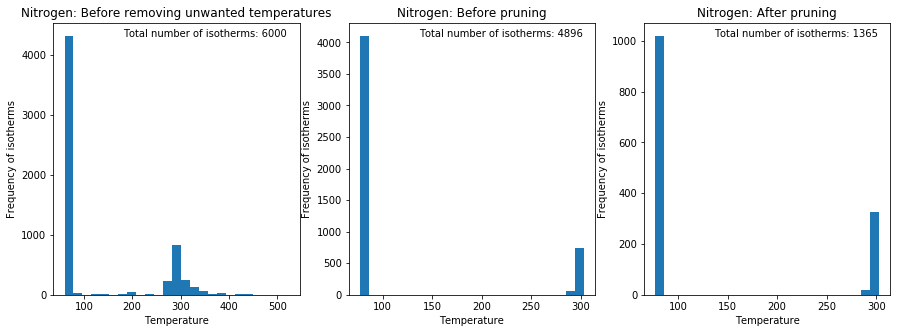

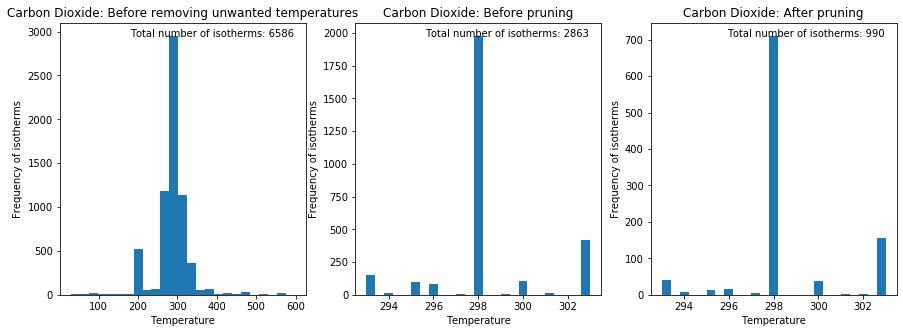

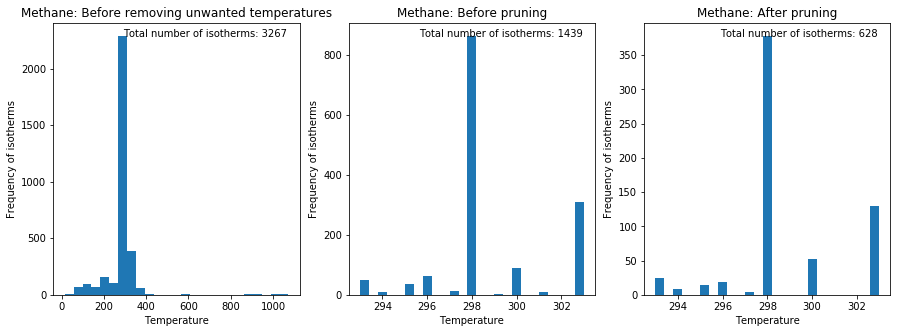

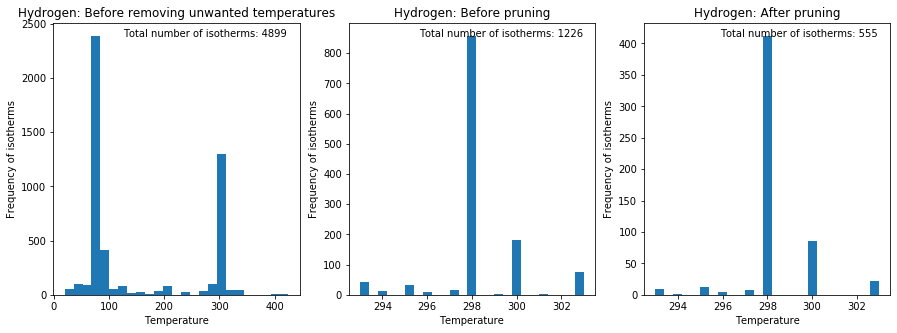

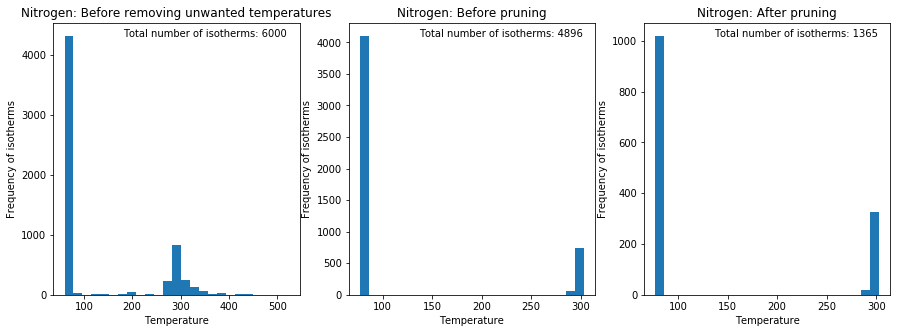

In [105]:
def inspect_temp_of_gas_isotherms(gas_name, min_data_points_for_pruning):
    assert gas_name in gas_to_key.keys()
    inchikey = gas_to_key[gas_name]
    
    temp_before_before = []
    temp_before = []
    temp_after = []
    for isotherm in np.array(experimental_isotherms):
        if isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_before_before.append(isotherm['temperature'])
    
    for isotherm in np.array(experimental_isotherms)[boolean_isotherm_array]:
        if isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_before.append(isotherm['temperature'])
    
    keep_row, keep_column = prune_matrix(min_data_points_for_pruning, False)
    for isotherm in np.array(experimental_isotherms)[boolean_isotherm_array]:
        i_col = gas_temp_to_column[isotherm['adsorbates'][0]['InChIKey'] + temp_groups[isotherm['temperature']]]
        i_row = mof_to_row[isotherm['adsorbent']['hashkey']]
        if keep_row[i_row] and keep_column[i_col] and isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_after.append(isotherm['temperature'])

    def create_subplot(ax, temp, title_label):
        ax.hist(temp, bins=25)
        ax.set_xlabel('Temperature')
        ax.set_ylabel('Frequency of isotherms')
        ax.set_title(title_label)
        ax.text(0.95, 0.95, 'Total number of isotherms: {}'.format(len(temp)), 
            horizontalalignment='right', transform=ax.transAxes)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    create_subplot(axs[0], temp_before_before, gas_name + ': Before removing unwanted temperatures')
    create_subplot(axs[1], temp_before, gas_name + ': Before pruning')
    create_subplot(axs[2], temp_after, gas_name + ': After pruning')
    plt.show()
    
sums = np.sum(mof_gas_frequency, axis=0)
old_order = np.array([i for i in range(len(sums))])

new_order = sorted(old_order, key=lambda x: sums[x], reverse=True)
most_common_gases = [key_to_gas[column_to_gas_temp[i].split('_')[0]] for i in new_order]


for gas in most_common_gases[:5]:
    inspect_temp_of_gas_isotherms(gas, 5)

## Plotting the sparsed matrix and the original matrix side by side

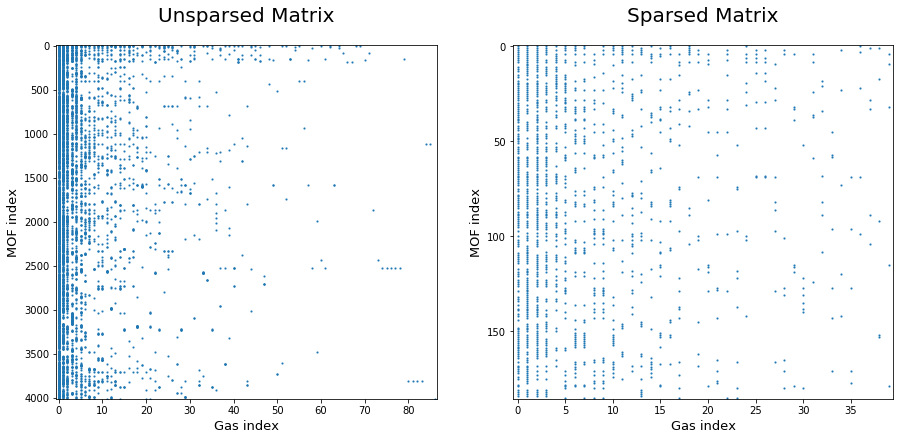

In [106]:
def plot_sparsity(col_or_row, min_data_points):
    assert col_or_row in ['col', 'row']
    
    keep_row, keep_column = prune_matrix(min_data_points, False)
    fig = plt.figure(figsize = (15,6.5))

    #subplot for the unsparsed matrix
    sorted_matrix = sort_matrix_by_freq(mof_gas_matrix, col_or_row) 
    ax = plt.subplot(121)
    plt.spy(sorted_matrix, aspect='auto', markersize=1)
    plt.title('Unsparsed Matrix',fontsize = 20)
    plt.xlabel('Gas index',fontsize = 13)
    plt.ylabel('MOF index',fontsize = 13)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')


    #subplot the sparsed matrix 
    sorted_sparsed_matrix = sort_matrix_by_freq(np.copy(mof_gas_matrix[keep_row, :][:, keep_column]), col_or_row)
    ax = plt.subplot(122)
    plt.spy(sorted_sparsed_matrix, aspect = 'auto',markersize=1)
    plt.title('Sparsed Matrix',fontsize = 20)
    plt.xlabel('Gas index',fontsize = 13)
    plt.ylabel('MOF index',fontsize = 13)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    plt.show()

plot_sparsity('col', 5)
#plot_sparsity('row', 5)

# Plotting the frequency of isotherms per gas/MOF

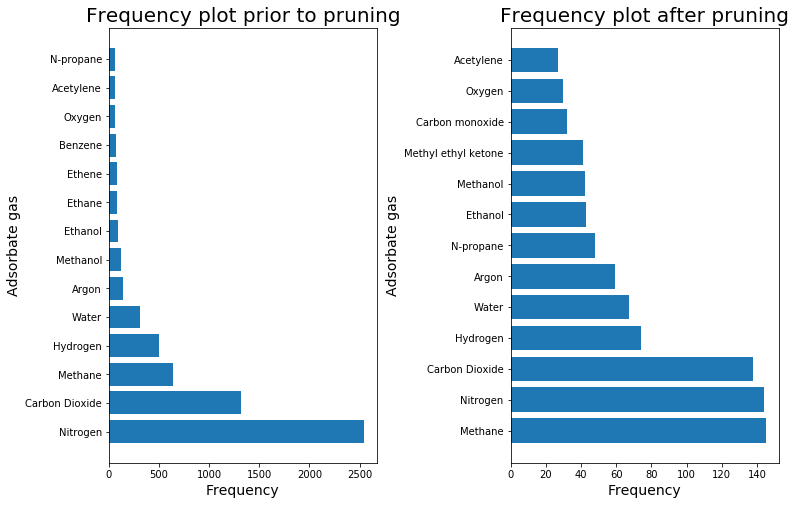

In [110]:
def plot_frequency_of_gas_or_mof(gas_or_mof, min_data_points_for_pruning):
    assert gas_or_mof.lower() in ['gas', 'mof']
    
    gas_or_mof_axis = np.int(gas_or_mof == 'mof')
    gas_or_mof_sum = np.sum(mof_gas_matrix, axis=gas_or_mof_axis)
    old_order = np.arange(len(gas_or_mof_sum))
    new_order = sorted(old_order, key=lambda x: gas_or_mof_sum[x], reverse=True)
    
    sums = np.sum(mof_gas_matrix, axis=gas_or_mof_axis)

    most_common_gases = np.full(len(sums), "", dtype='object')
    for (i, o) in enumerate(new_order):
        most_common_gases[i] = (key_to_gas[column_to_gas_temp[o].split('_')[0]])

    keep_row, keep_column = prune_matrix(min_data_points_for_pruning, False)
    
    gas_or_mof_sparsed_sum = np.sum(mof_gas_matrix[keep_row, :][:, keep_column], axis=gas_or_mof_axis)
    sparsed_old_order = np.arange(len(gas_or_mof_sparsed_sum))
    sparsed_new_order = sorted(sparsed_old_order, key=lambda x: gas_or_mof_sparsed_sum[x], reverse=True)
    
    sparsed_sums = np.sum(mof_gas_matrix[keep_row, :][:, keep_column], axis=gas_or_mof_axis)

    most_common_sparsed_gases = np.full(len(sparsed_sums), "", dtype='object')
    for (i, o) in enumerate(sparsed_new_order):
        most_common_sparsed_gases[i] = (key_to_gas[column_to_gas_temp[o].split('_')[0]])
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    axs[0].barh(most_common_gases[0:15], gas_or_mof_sum[new_order][0:15])
    axs[0].set_xlabel('Frequency', fontsize=14)
    axs[0].set_ylabel('Adsorbate gas', fontsize=14)
    axs[0].set_title('Frequency plot prior to pruning', fontsize=20)
    axs[1].barh(most_common_sparsed_gases[0:15], gas_or_mof_sparsed_sum[sparsed_new_order][0:15])
    axs[1].set_xlabel('Frequency', fontsize=14)
    axs[1].set_ylabel('Adsorbate gas', fontsize=14)
    axs[1].set_title('Frequency plot after pruning', fontsize=20)
    
    fig.subplots_adjust(wspace=0.5)
    plt.show()
plot_frequency_of_gas_or_mof('gas', 5)

## Minimum data point requirement vs sparsity of matrix graph

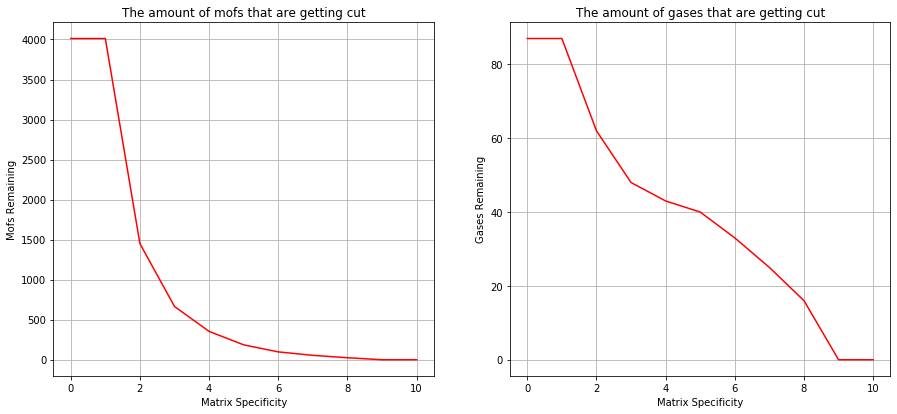

In [111]:
point_requirement_matrix = np.copy(mof_gas_matrix)
matrix_sum = np.sum(point_requirement_matrix)
gases_cut = 0
mofs_cut = 0
count = 0
cut_mofs = []
cut_gases = []

for n in range(11):
    while True:
        
        mofs_cut = 0
        gases_cut = 0
        
        for row in range(len(mof_to_row)):
            if np.sum(point_requirement_matrix[row,:]) < n:
                point_requirement_matrix[row,:] = False
        
        for column in range(len(gas_temp_to_column)):
            if np.sum(point_requirement_matrix[:,column]) < n:
                point_requirement_matrix[:,column] = False
    
        if matrix_sum == np.sum(point_requirement_matrix):
            break
        
        matrix_sum = np.sum(point_requirement_matrix)
        count += 1
    
    for row in range(len(mof_to_row)):
        if point_requirement_matrix.sum(axis = 1)[row] == 0:
            mofs_cut += 1
    
    for column in range(len(gas_temp_to_column)):
        if point_requirement_matrix.sum(axis = 0)[column] == 0:
            gases_cut += 1
            
    cut_mofs.append(len(mof_to_row) - mofs_cut)
    cut_gases.append(len(gas_temp_to_column) - gases_cut)   

#Plots how the the gases and the mofs act with an increase in matrix specificity
n = range(11)
plt.figure(figsize = (15,6.5))

plt.subplot(121)
plt.plot(n,cut_mofs,'r')
plt.title('The amount of mofs that are getting cut')
plt.ylabel('Mofs Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()

plt.subplot(122)
plt.plot(n,cut_gases,'r')
plt.title('The amount of gases that are getting cut')
plt.ylabel('Gases Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()
plt.show()
#TODO plot the graphs as points

# Write Data Matrix to a Pandas DataFrame and write it to a file:

In [113]:
mof_gas_dataframe = pd.DataFrame(data=np.array(mof_gas_matrix[:, keep_column][keep_row, :]),
                                 columns=[column_to_gas_temp[i] for i in np.arange(mof_gas_matrix.shape[1])[keep_column]],
                                 index=[row_to_mof[i] for i in np.arange(mof_gas_matrix.shape[0])[keep_row]],
                                dtype=int)

mof_gas_dataframe.to_csv('mof_gas_dataframe.csv')
mof_gas_dataframe

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_77K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,...,WEVYAHXRMPXWCK-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,RWSOTUBLDIXVET-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,LRHPLDYGYMQRHN-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K,QWTDNUCVQCZILF-UHFFFAOYSA-N_298K
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,0,1,1,1,1,1,0,...,0,0,0,0,0,1,1,0,0,0
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,1,0,0,1
NIST-MATDB-9f02824618e94d86caedc9fb497366ba,1,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,1,0,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
NIST-MATDB-e23e0f3921a269533d74caae8c5a12bf,1,1,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
NIST-MATDB-a32141d840ee476b01d03de6aabc5dd0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
